In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix, roc_auc_score, auc

In [2]:
df = pd.read_csv('C:/Users/cheryl/Downloads/df_for_model.csv', encoding='latin-1')

In [3]:
embedded_cols = ["Job Title_embed","Profile_embed","Department_embed","Job_Description_embed","Requirements_embed",
                "Job_Benefits_embed","Type_of_Industry_embed","Operations_embed","City_embed"]
categorical_feats = ["Qualification_bachelor's degree", "Salary_Specified", "Type_of_Employment_unspecified",
                     "Qualification_high school", "City_Specified", "Experience_entry level","Qualification_master's degree",
                     "Experience_unspecified", "Telecomunication","Qualification_vocational / certification/ professional",
                     "Experience_midsenior level", "Qualification_unspecified", "Type_of_Employment_fulltime"]

In [4]:
def convert_to_array(s):
    # Clean the string
    cleaned_str = s.strip('[]').replace('\n', ' ').replace('  ', ' ').strip()
    # Convert the cleaned string to a NumPy array
    return np.fromstring(cleaned_str, sep=' ')

for col in embedded_cols:
    df[col] = df[col].apply(convert_to_array)

In [5]:
scaler = StandardScaler()
X_text = np.hstack([np.vstack(df[col]) for col in embedded_cols])
X_cat = df[categorical_feats].values
X_num = df[['Range_of_Salary']]
X = np.hstack([X_text, X_cat, X_num])

X_std = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_std)

# Plot Explained Variance Ratio
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

In [ ]:
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Principal Components')
plt.show()

In [6]:
pca = PCA(n_components = 700)
X_pca = pca.fit_transform(X_std)
explained_variance = pca.explained_variance_ratio_
variance_first_700 = explained_variance.sum()
print(f"Variance explained by first 700 components: {variance_first_700:.3f}")

Variance explained by first 700 components: 0.920


In [7]:
df1 = pd.DataFrame(X_pca)

In [13]:
y = df['Fraudulent']
X_train, X_test, y_train, y_test = train_test_split(df1, y, test_size = 0.2, random_state = 4263)
print(X_train.shape) 
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8524, 700)
(2132, 700)
(8524,)
(2132,)


In [9]:
print("Counts of label '1' in training data: {}".format(sum(y_train == 1)))
print("Counts of label '0' in training data: {}".format(sum(y_train == 0)))

Counts of label '1' in training data: 588
Counts of label '0' in training data: 7936


In [14]:
def resampling_method(method,X_train,y_train):
    if method == 'Undersampling':
        rus = RandomUnderSampler(random_state=4263)
        X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)
    elif method == 'Oversampling':
        ros = RandomOverSampler(random_state=4263)
        X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)
    else:
        print('Invalid resampling method')
    resampled_class_counts = pd.Series(y_train_balanced).value_counts()
    print("Resampled class counts:")
    print(resampled_class_counts)
    return X_train_balanced, y_train_balanced
        

In [86]:
X_train_balanced, y_train_balanced = resampling_method('Undersampling',X_train,y_train)

Resampled class counts:
0    588
1    588
Name: Fraudulent, dtype: int64


In [32]:
logistic_model = LogisticRegression(max_iter = 500, random_state = 4263, penalty='l1', solver='liblinear')

logistic_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = logistic_model.predict(X_test)

Resampled class counts:
0    7936
1    7936
Name: Fraudulent, dtype: int64


In [21]:
def evaluate_model(y_test,y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix for {model_name}')
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return cm

Accuracy: 0.9601313320825516
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1990
           1       0.71      0.69      0.70       142

    accuracy                           0.96      2132
   macro avg       0.84      0.83      0.84      2132
weighted avg       0.96      0.96      0.96      2132



array([[1949,   41],
       [  44,   98]], dtype=int64)

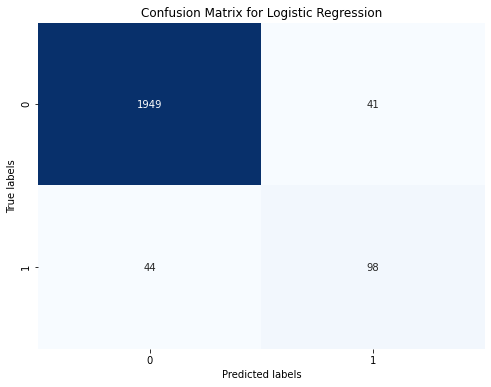

In [24]:
evaluate_model(y_test,y_pred,'Logistic Regression')

In [25]:
def auc_roc(model,model_name,X_test,y_test):
    pred_prob = model.predict_proba(X_test)
    auc_score = round(roc_auc_score(y_test, pred_prob[:,1]),3)
    fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)
    plt.plot(fpr, tpr, linestyle='--',color='orange', label ='ROC curve (area = %0.3f)' % auc_score)
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()
    
    return print(f'AUC score: {auc_score}')
    

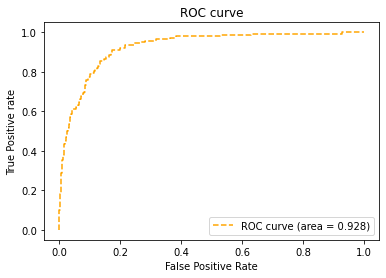

AUC score: 0.928


In [78]:
auc_roc(model,'Logistic Regression',X_test,y_test)

In [26]:
rfc = RandomForestClassifier(random_state = 4263, max_features='sqrt',n_estimators=100,max_depth = 10, n_jobs=-1)
rfc.fit(X_train_balanced, y_train_balanced)
y_pred = rfc.predict(X_test)

Accuracy: 0.9638836772983115
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1990
           1       0.99      0.46      0.63       142

    accuracy                           0.96      2132
   macro avg       0.97      0.73      0.81      2132
weighted avg       0.96      0.96      0.96      2132



array([[1989,    1],
       [  76,   66]], dtype=int64)

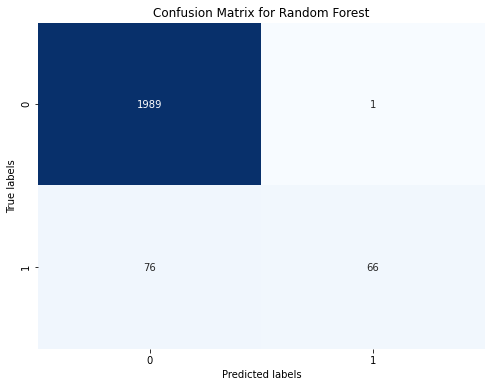

In [27]:
evaluate_model(y_test,y_pred,'Random Forest')

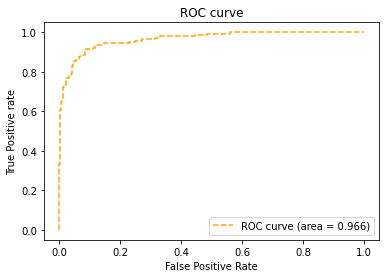

AUC score: 0.966


In [29]:
auc_roc(rfc,'Random Forest',X_test,y_test)

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [31]:
num_features = X_train_balanced.shape[1]
print(num_features)

700


In [80]:
# Build the model
nn_model = Sequential([
    Input(shape=(num_features,)),  # Input layer
    Dense(128, activation='relu'), # First hidden layer
    Dense(64, activation='relu'),  # Second hidden layer
    Dense(32, activation='relu'),  # Third hidden layer
    Dense(1, activation='sigmoid') # Output layer (binary classification)
])
optimizer = Adam(learning_rate=0.001)  
nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
nn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               89728     
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 100097 (391.00 KB)
Trainable params: 100097 (391.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [87]:
nn_model.fit(X_train_balanced,
             y_train_balanced,
             epochs=10, 
             batch_size=32,
             validation_data=(X_test, y_test))

Epoch 1/10
37/37 [==============================] - 1s 8ms/step - loss: 4.9860e-06 - accuracy: 1.0000 - val_loss: 0.1928 - val_accuracy: 0.9798
Epoch 2/10
37/37 [==============================] - 0s 7ms/step - loss: 4.7205e-06 - accuracy: 1.0000 - val_loss: 0.1929 - val_accuracy: 0.9798
Epoch 3/10
37/37 [==============================] - 0s 7ms/step - loss: 4.4594e-06 - accuracy: 1.0000 - val_loss: 0.1929 - val_accuracy: 0.9798
Epoch 4/10
37/37 [==============================] - 0s 7ms/step - loss: 4.2381e-06 - accuracy: 1.0000 - val_loss: 0.1929 - val_accuracy: 0.9798
Epoch 5/10
37/37 [==============================] - 0s 7ms/step - loss: 4.0471e-06 - accuracy: 1.0000 - val_loss: 0.1930 - val_accuracy: 0.9798
Epoch 6/10
37/37 [==============================] - 0s 8ms/step - loss: 3.8688e-06 - accuracy: 1.0000 - val_loss: 0.1930 - val_accuracy: 0.9798
Epoch 7/10
37/37 [==============================] - 0s 9ms/step - loss: 3.7070e-06 - accuracy: 1.0000 - val_loss: 0.1930 - val_accuracy:

In [88]:
loss, accuracy = nn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

67/67 [==============================] - 0s 2ms/step - loss: 0.1930 - accuracy: 0.9794
Test Accuracy: 0.9794


In [89]:
y_pred = nn_model.predict(X_test)

67/67 [==============================] - 0s 2ms/step


In [90]:
y_pred = np.round(y_pred).tolist()

Accuracy: 0.9793621013133208
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1990
           1       0.91      0.77      0.83       142

    accuracy                           0.98      2132
   macro avg       0.95      0.88      0.91      2132
weighted avg       0.98      0.98      0.98      2132



array([[1979,   11],
       [  33,  109]], dtype=int64)

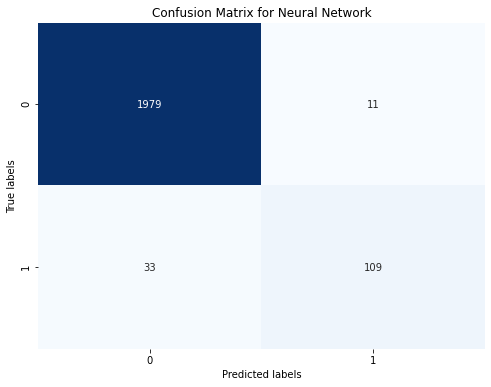

In [91]:
evaluate_model(y_test,y_pred,'Neural Network')